<a href="https://colab.research.google.com/github/daichan425/my-first-webpage/blob/main/Pre_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("tawsifurrahman/covid19-radiography-database")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'covid19-radiography-database' dataset.
Path to dataset files: /kaggle/input/covid19-radiography-database


In [2]:
import kagglehub
import pandas as pd

# Download latest version
path = kagglehub.dataset_download("preetviradiya/covid19-radiography-dataset")
print("Path to dataset root:", path)

data_path = f'{path}/COVID-19_Radiography_Dataset/COVID-19_Radiography_Dataset'
print("Path to dataset files:", path)
from torchvision import datasets, transforms

# 元データは299×299のグレースケール画像
# transformは変更しても良い
IMAGE_SIZE = 224 # 変更しても良い

transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor()
])

dataset = datasets.ImageFolder(
    root=data_path,
    transform=transform
)

print("--- Dataset detail ---")
print(dataset)
print("\n--- Dataset classes ---")
print(dataset.classes)
print("\n--- Number of data points per class ---")
display(pd.Series(dataset.targets).replace({num: label for num, label in zip(range(len(dataset.classes)), dataset.classes)}).value_counts())

from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
import numpy as np

targets = np.array(dataset.targets)

# IDを訓練用とテスト用に分割 (例: 80%を訓練、20%をテスト)
TEST_SIZE_RATIO = 0.2
RANDOM_SEED = 42 # 再現性の確保

train_idx, test_idx = train_test_split(
    np.arange(len(targets)),
    test_size=TEST_SIZE_RATIO,
    stratify=targets,
    random_state=RANDOM_SEED
)

print("\n--- Train dataset ---")
train_ds = Subset(dataset, train_idx)
print(f"Number of Train samples: {len(train_ds)}")

print("\n--- Test dataset ---")
test_ds  = Subset(dataset, test_idx)
print(f"Number of Test samples: {len(test_ds)}")

print("\n--- Number of Train data points per class ---")
display(pd.Series(dataset.targets)[train_idx].replace({num: f"{num}:{label}" for num, label in zip(range(len(dataset.classes)), dataset.classes)}).value_counts())

print("\n--- Number of Test data points per class ---")
display(pd.Series(dataset.targets)[test_idx].replace({num: f"{num}:{label}" for num, label in zip(range(len(dataset.classes)), dataset.classes)}).value_counts())

Using Colab cache for faster access to the 'covid19-radiography-dataset' dataset.
Path to dataset root: /kaggle/input/covid19-radiography-dataset
Path to dataset files: /kaggle/input/covid19-radiography-dataset
--- Dataset detail ---
Dataset ImageFolder
    Number of datapoints: 21165
    Root location: /kaggle/input/covid19-radiography-dataset/COVID-19_Radiography_Dataset/COVID-19_Radiography_Dataset
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

--- Dataset classes ---
['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']

--- Number of data points per class ---


,count
Normal,10192
Lung_Opacity,6012
COVID,3616
Viral Pneumonia,1345



--- Train dataset ---
Number of Train samples: 16932

--- Test dataset ---
Number of Test samples: 4233

--- Number of Train data points per class ---


,count
2:Normal,8154
1:Lung_Opacity,4809
0:COVID,2893
3:Viral Pneumonia,1076



--- Number of Test data points per class ---


,count
2:Normal,2038
1:Lung_Opacity,1203
0:COVID,723
3:Viral Pneumonia,269


In [3]:
import torch
import torch.nn as nn
from torchvision import models, transforms

# 1. 訓練用：データ拡張あり
train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),      # 左右反転
    transforms.RandomRotation(degrees=10),       # 5〜10度の回転
    transforms.ColorJitter(brightness=0.2, contrast=0.2), # 輝度・コントラスト調整
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # 共通の正規化
])

# 2. テスト用：リサイズとテンソル化のみ（拡張なし）
test_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Subsetに異なるtransformを適用するためのクラス定義
class ApplyTransform(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform: x = self.transform(x)
        return x, y
    def __len__(self):
        return len(self.subset)

# 分割済みのインデックスに対してTransformを割り当て
# 元のdatasetのtransformをNoneに上書きしておく必要があります
dataset.transform = None
train_ds_final = ApplyTransform(train_ds, transform=train_transform)
test_ds_final = ApplyTransform(test_ds, transform=test_transform)

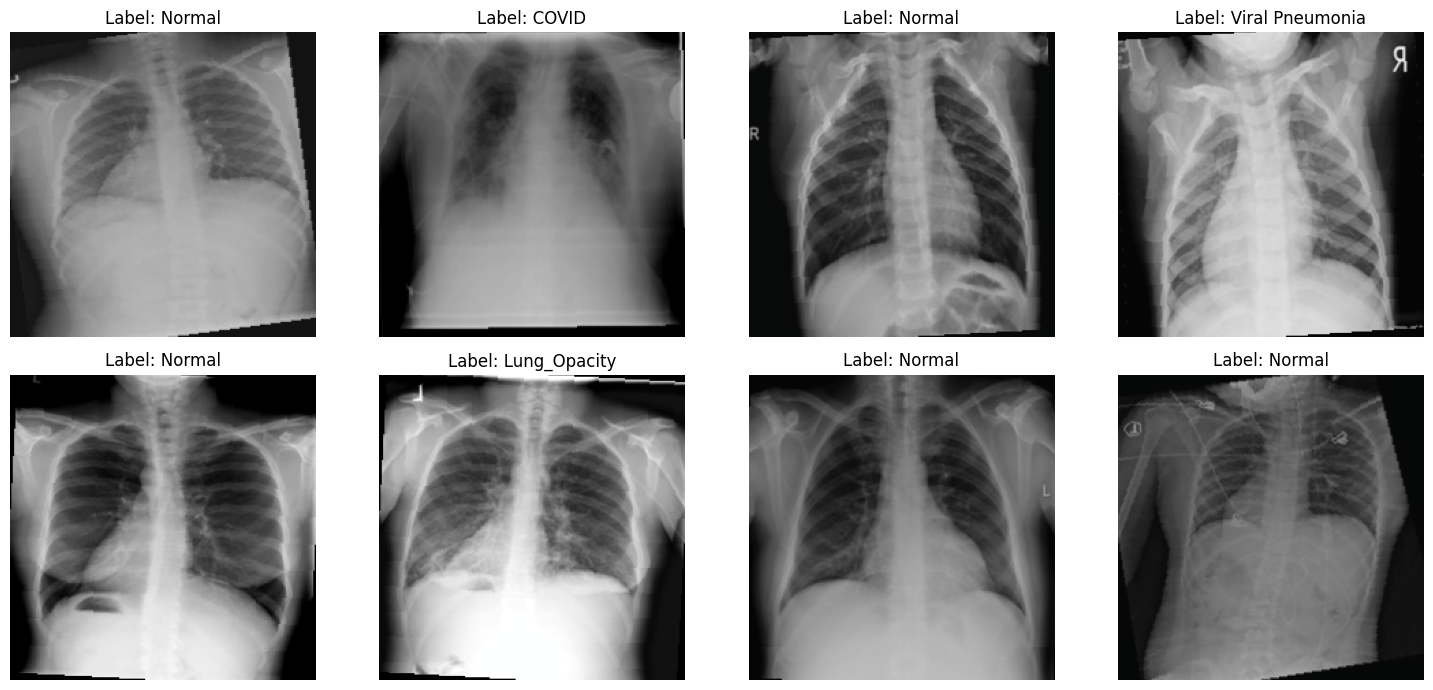

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# 1. 前処理（Transforms）の定義
# 訓練用：データ拡張あり
train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),      # 左右反転
    transforms.RandomRotation(degrees=10),       # 5〜10度の回転
    transforms.ColorJitter(brightness=0.2, contrast=0.2), # 輝度・コントラスト調整
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # 共通の正規化
])

# SubsetにTransformを適用するためのクラス
class ApplyTransform(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform: x = self.transform(x)
        return x, y
    def __len__(self):
        return len(self.subset)

# 元のdatasetのtransformを一時的にNoneにして、個別に適用する
dataset.transform = None
train_ds_final = ApplyTransform(train_ds, transform=train_transform)

# 2. 表示用の関数（正規化を元に戻して表示）
def imshow(img, title):
    img = img.numpy().transpose((1, 2, 0))
    # 正規化を解除 (mean/stdを戻す)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')

# 3. 訓練データからいくつか取り出して表示
plt.figure(figsize=(15, 7))
for i in range(8):
    image, label_idx = train_ds_final[i] # 同じ画像を何度か表示しても拡張がランダムなので変わる
    label_name = dataset.classes[label_idx]

    plt.subplot(2, 4, i + 1)
    imshow(image, f"Label: {label_name}")

plt.tight_layout()
plt.show()

In [5]:
import torch
from torch.utils.data import DataLoader, WeightedRandomSampler

# 1. 各クラスの重みを計算（不均衡対策）
# 訓練データにおける各サンプルのラベルを取得
train_labels = [dataset.targets[i] for i in train_idx]
class_counts = np.bincount(train_labels) # 各クラスの枚数をカウント
class_weights = 1. / torch.tensor(class_counts, dtype=torch.float) # 枚数の逆数を重みにする
sample_weights = class_weights[train_labels] # 全訓練サンプルに対する重みのリスト

# 重みに基づいてサンプリングするSampler
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True # 重複を許容して少ないクラスを何度も選ぶ
)

# 2. DataLoaderの作成
BATCH_SIZE = 32

train_loader = DataLoader(
    train_ds_final,
    batch_size=BATCH_SIZE,
    sampler=sampler, # ここで不均衡対策を適用
    num_workers=2
)

test_loader = DataLoader(
    test_ds_final,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2
)

print(f"DataLoader準備完了。1バッチあたりのサイズ: {BATCH_SIZE}")

DataLoader準備完了。1バッチあたりのサイズ: 32


In [6]:
import torch.nn as nn
from torchvision import models

# 1. 事前学習済みResNet-18のロード
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
# 2. 最終層の変更（1000クラス → 4クラス）
# ResNet-18の最終層(fc)の入力数（512）を取得し、出力を4に変更します
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 4)
# インプレース操作（上書き）
def disable_inplace(model):
    for module in model.modules():
        if hasattr(module, 'inplace'):
            module.inplace = False

# 関数を適用
disable_inplace(model)

# 3. デバイスの設定（GPUが使えるならGPUへ転送）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# 4. 損失関数と最適化アルゴリズムの設定
# 分類問題の定番 CrossEntropyLoss を使用
criterion = nn.CrossEntropyLoss()

# ファインチューニングなので学習率は小さめに設定(0.0001)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

print(f"モデルの構築が完了しました。使用デバイス: {device}")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 145MB/s]


モデルの構築が完了しました。使用デバイス: cuda


In [7]:
import time
import copy

# エポック数の設定（まずは10エポック程度で様子を見ます）
num_epochs = 10
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0

# 経過を記録するリスト
history = {'train_loss': [], 'test_acc': []}

print("学習を開始します...")
since = time.time()

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    print('-' * 10)

    # --- 訓練フェーズ ---
    model.train()  # モデルを訓練モードに設定
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # 勾配のリセット
        optimizer.zero_grad()

        # 順伝播（Forward）
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # 逆伝播 + 最適化（Backward + Step）
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_ds_final)
    history['train_loss'].append(epoch_loss)

    # --- 評価フェーズ ---
    model.eval()  # モデルを評価モードに設定
    running_corrects = 0

    with torch.no_grad(): # 勾配計算をオフにする
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)

    epoch_acc = running_corrects.double() / len(test_ds_final)
    history['test_acc'].append(epoch_acc.item())

    print(f'Train Loss: {epoch_loss:.4f}  Test Acc: {epoch_acc:.4f}')

    # 最良モデルの保存
    if epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())

time_elapsed = time.time() - since
print(f'\n学習完了！ 所要時間: {time_elapsed // 60:.0f}分 {time_elapsed % 60:.0f}秒')
print(f'最高正解率: {best_acc:4f}')

# 最良の重みをモデルにロード
model.load_state_dict(best_model_wts)
# 1. モデルの保存
model_path = "/content/drive/MyDrive/zemi/best_model.pth"
torch.save(model.state_dict(), model_path)

学習を開始します...
Epoch 1/10
----------
Train Loss: 0.2789  Test Acc: 0.9227
Epoch 2/10
----------
Train Loss: 0.1664  Test Acc: 0.8918
Epoch 3/10
----------
Train Loss: 0.1372  Test Acc: 0.9414
Epoch 4/10
----------
Train Loss: 0.1251  Test Acc: 0.9362
Epoch 5/10
----------
Train Loss: 0.1209  Test Acc: 0.9348
Epoch 6/10
----------
Train Loss: 0.0967  Test Acc: 0.9015
Epoch 7/10
----------
Train Loss: 0.1008  Test Acc: 0.9220
Epoch 8/10
----------
Train Loss: 0.0854  Test Acc: 0.9459
Epoch 9/10
----------
Train Loss: 0.0786  Test Acc: 0.9386
Epoch 10/10
----------
Train Loss: 0.0785  Test Acc: 0.9372

学習完了！ 所要時間: 21分 21秒
最高正解率: 0.945901


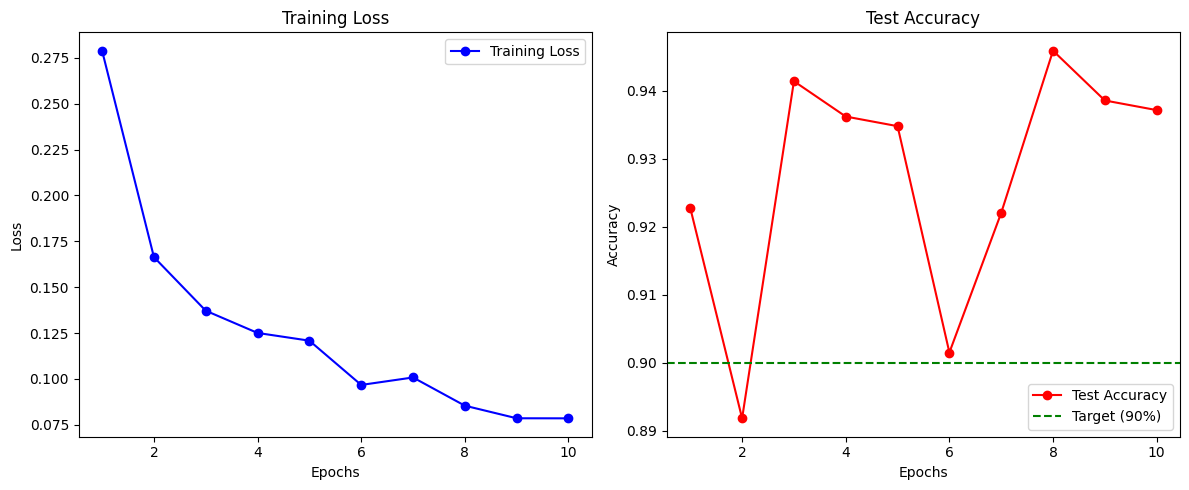

In [19]:
# --- ② グラフの描画 ---
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# Lossのグラフ
plt.subplot(1, 2, 1)
plt.plot(epochs, history['train_loss'], 'bo-', label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracyのグラフ
plt.subplot(1, 2, 2)
plt.plot(epochs, history['test_acc'], 'ro-', label='Test Accuracy')
plt.axhline(y=0.9, color='green', linestyle='--', label='Target (90%)') # 目標線
plt.title('Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# 3. グラフを画像として保存
plt.tight_layout() # ラベルの重なりを防ぐ
plt.savefig('/content/drive/MyDrive/zemi/gragh', dpi=300) # 高解像度(300dpi)で保存


plt.tight_layout()
plt.show()


✅ 混同行列のグラフを保存しました: /content/drive/MyDrive/zemi/confusion_matrix


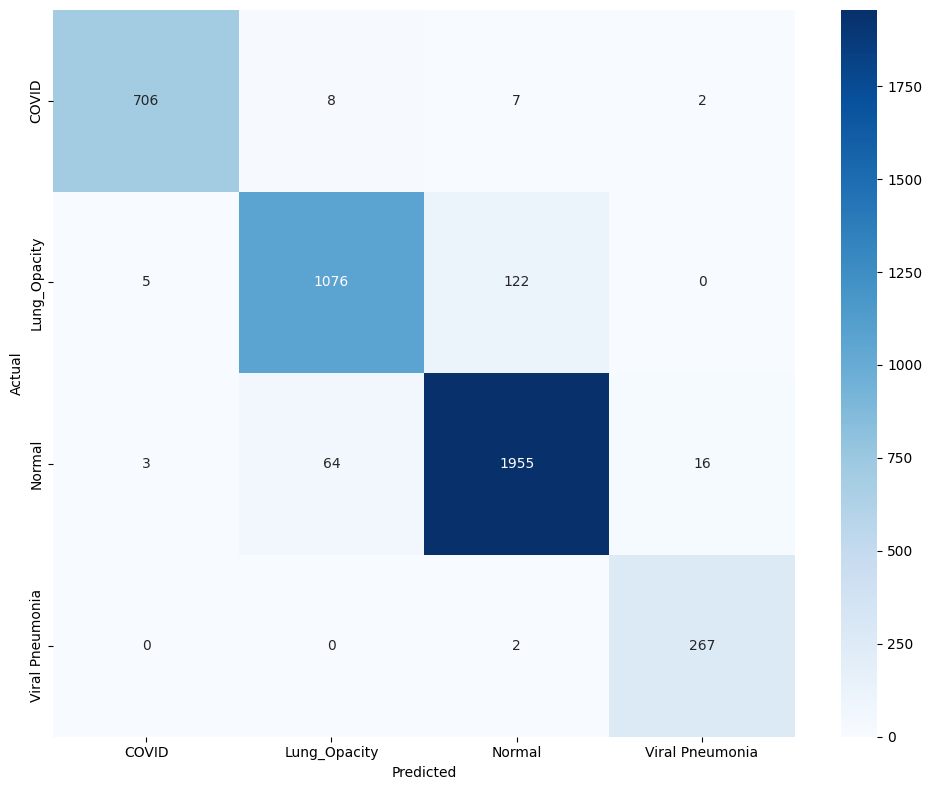


--- Classification Report ---
                 precision    recall  f1-score   support

          COVID       0.99      0.98      0.98       723
   Lung_Opacity       0.94      0.89      0.92      1203
         Normal       0.94      0.96      0.95      2038
Viral Pneumonia       0.94      0.99      0.96       269

       accuracy                           0.95      4233
      macro avg       0.95      0.96      0.95      4233
   weighted avg       0.95      0.95      0.95      4233



In [24]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt # グラフ保存のために必要
import os # パス操作のために必要

# 予測値と正解ラベルの取得
all_preds = []
all_labels = []

model.eval() # モデルを評価モードに設定
with torch.no_grad(): # 勾配計算をオフにする
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# 混同行列の計算
cm = confusion_matrix(all_labels, all_preds)

# --- 混同行列の可視化と保存 ---
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout() # レイアウト調整

# グラフをファイルとして保存
# 保存先パスを作成 (例: "Adam_Base_Rotate10/confusion_matrix.png")
cm_save_path = "/content/drive/MyDrive/zemi/confusion_matrix"
plt.savefig(cm_save_path, dpi=300) # 高解像度で保存


plt.show() # 画面にも表示

# 精度の詳細レポート
print("\n--- Classification Report ---")
print(classification_report(all_labels, all_preds, target_names=dataset.classes))

(1, 3, 224, 224, 4)
各クラス（Normal, Lung_Opacity, COVID, Viral Pneumonia）への反応:


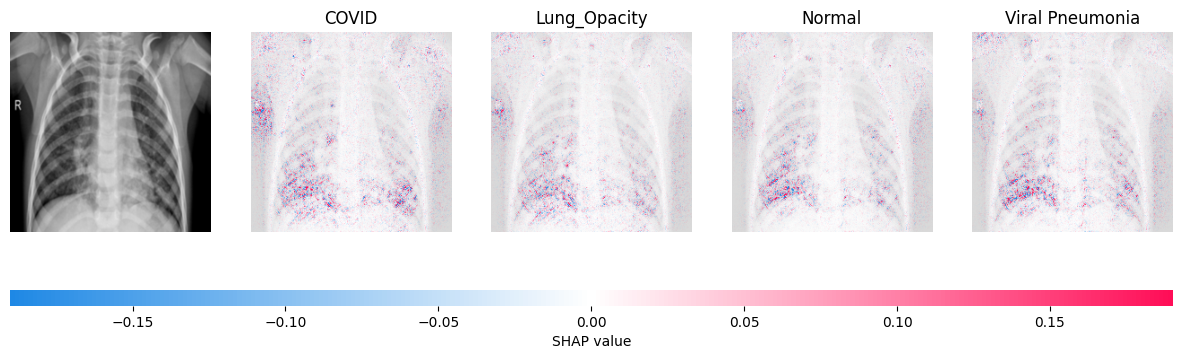

<Figure size 640x480 with 0 Axes>

In [40]:
import numpy as np
import shap
import torch

# 1. 逆正規化関数の定義（Clipping警告対策）
def denormalize(tensor):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = tensor.cpu().numpy().transpose(1, 2, 0)
    img = std * img + mean
    return np.clip(img, 0, 1)

# 2. SHAP解析用のデータ準備（1枚だけ詳しく見る場合）
test_batch = next(iter(test_loader))
test_images, _ = test_batch
target_image = test_images[0:1].to(device) # 先頭の1枚を抽出
train_batch = next(iter(train_loader))
background = train_batch[0][:20].to(device)


# 3. SHAP値の計算
explainer = shap.GradientExplainer(model, background)
shap_values = explainer.shap_values(target_image)
# print(shap_values.shape)

# 4. データの整形（ValueError対策）
# shap_valuesは [クラス0, クラス1, クラス2, クラス3] のリスト形式
# それぞれを (1, 224, 224, 3) に変換
# shap_numpy = [np.transpose(s, (0, 2, 3, 1)) for s in shap_values]
shap_numpy = []
for i in range(4): # 4クラス分ループ
    # i番目のクラスを抽出 -> (1, 3, 224, 224)
    s = shap_values[..., i]
    # 軸を入れ替え (1, 3, 224, 224) -> (1, 224, 224, 3)
    s_transposed = np.transpose(s, (0, 2, 3, 1))
    shap_numpy.append(s_transposed)
test_numpy = np.array([denormalize(target_image[0])])

# 5. 可視化
# 1枚の画像に対して、全4クラスのヒートマップが横に並びます
#print("各クラス（Normal, Lung_Opacity, COVID, Viral Pneumonia）への反応:")
shap.image_plot(shap_numpy, test_numpy, labels=[dataset.classes])

# 6. 保存（NameError対策）
plt.savefig('/content/drive/MyDrive/zemi/shap_result.png')

In [26]:
model = models.resnet18(weights=None) # 構造のみ
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 4)

def disable_inplace(model):
    for module in model.modules():
        if hasattr(module, 'inplace'):
            module.inplace = False
disable_inplace(model) # RuntimeError対策
model = model.to(device)

In [27]:
# 保存した 94.5% の重みを読み込む
model.load_state_dict(torch.load('/content/drive/MyDrive/zemi/best_model.pth'))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv2): Conv2d(64, 64, kernel_s

IndexError: index 3 is out of bounds for axis 0 with size 3

<Figure size 2000x1000 with 0 Axes>

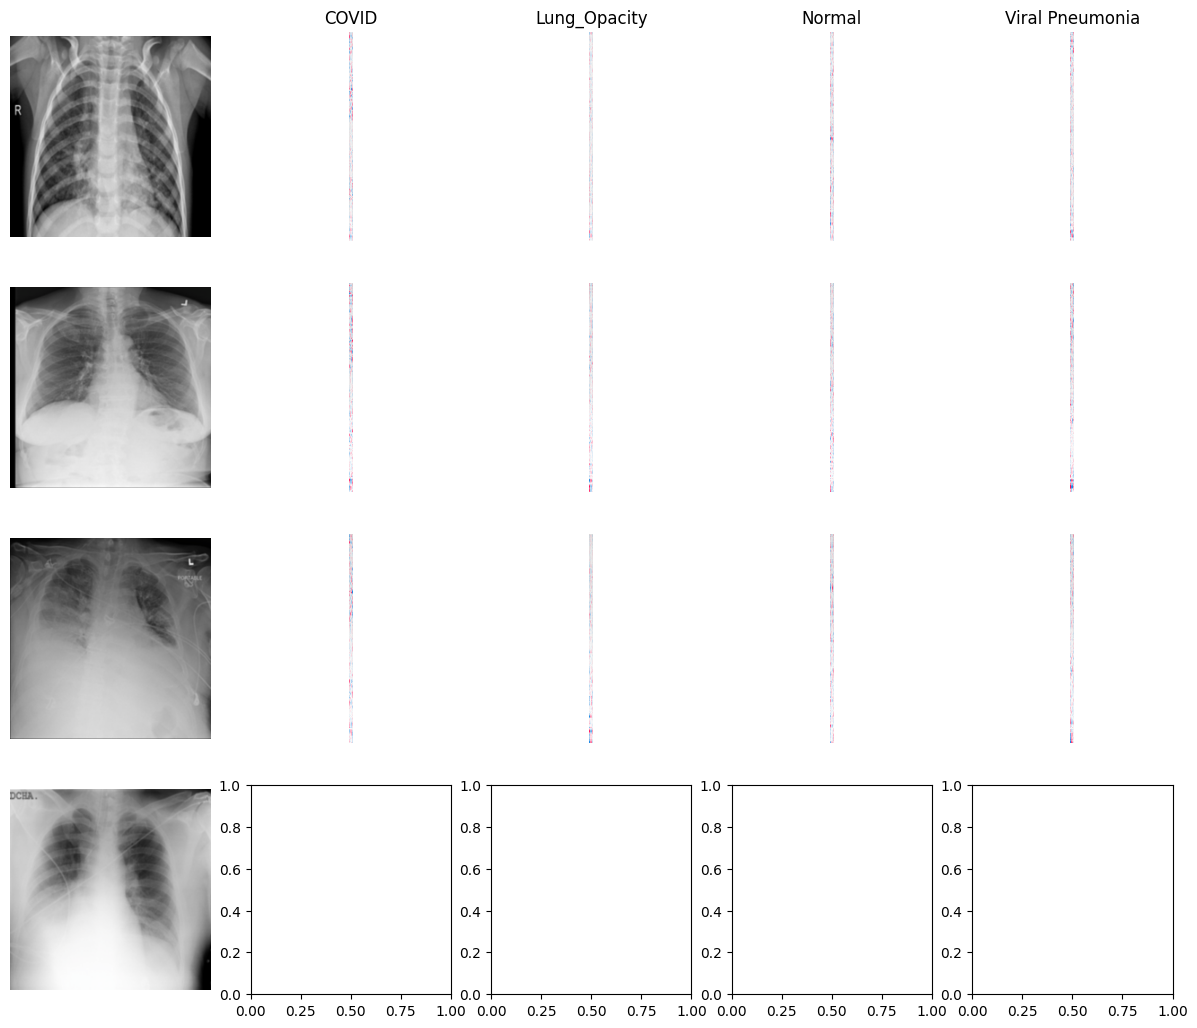

In [29]:
import torch
import numpy as np
import shap
import matplotlib.pyplot as plt

# 1. 各クラスの代表画像を1枚ずつ抽出
# ---------------------------------------------------------
images_per_class = []
labels_per_class = []
target_classes = [0, 1, 2, 3] # 4クラスすべて

# テストデータから各ラベルの最初の1枚を探す
found_classes = set()
for inputs, labels in test_loader:
    for i in range(len(labels)):
        label = labels[i].item()
        if label in target_classes and label not in found_classes:
            images_per_class.append(inputs[i])
            labels_per_class.append(label)
            found_classes.add(label)
    if len(found_classes) == 4:
        break

# 解析用に 4枚の画像を1つのバッチにまとめる
target_images = torch.stack(images_per_class).to(device)

# 2. 逆正規化関数の定義（白飛び・Clipping警告対策）
# ---------------------------------------------------------
def denormalize(tensor):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = tensor.cpu().numpy().transpose(1, 2, 0)
    img = std * img + mean
    return np.clip(img, 0, 1) # 0.0〜1.0に収める

# 3. SHAP解析の実行
# ---------------------------------------------------------
# ※ 94.5%の重みをロードした状態のmodelを使用すること
explainer = shap.GradientExplainer(model, background)
shap_values = explainer.shap_values(target_images)

# 4. データの整形（ValueError: size 4 into shape (3) 対策）
# ---------------------------------------------------------
# 各クラスに対するSHAP値を (枚数, H, W, C) に変換
shap_numpy = [np.transpose(s, (0, 2, 3, 1)) for s in shap_values]
# 元画像を人間が見える色合いに変換
test_numpy = np.array([denormalize(img) for img in target_images])

# 5. 可視化と保存
# ---------------------------------------------------------
plt.figure(figsize=(20, 10))
# 横軸にクラス名、縦軸に各サンプル画像が並びます
shap.image_plot(shap_numpy, test_numpy, labels=[dataset.classes])

# フォルダを指定して保存（NameError対策：パスを引用符で囲む）
save_path = f'./{experiment_name}/shap_comparison.png'
plt.savefig(save_path, dpi=300)
print(f"✅ 各クラスの比較画像を保存しました: {save_path}")